In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Load breast cancer dataset (binary classification)
data = load_breast_cancer()
X = data.data
y = data.target

In [3]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Create a base classifier (Decision Tree in this case)
base_clf = DecisionTreeClassifier(random_state=42)

# Create and train a simple BaggingClassifier with default parameters
bag_clf = BaggingClassifier(estimator=base_clf, random_state=42)
bag_clf.fit(X_train_scaled, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                  random_state=42)

In [7]:
# Evaluate initial model
y_pred = bag_clf.predict(X_test_scaled)
initial_accuracy = accuracy_score(y_test, y_pred)
print(f"Initial BaggingClassifier Accuracy: {initial_accuracy:.4f}")

Initial BaggingClassifier Accuracy: 0.9561


In [12]:
# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'estimator__max_depth': [None, 5, 10]
}

In [ ]:
Valid parameters are: ['bootstrap', 'bootstrap_features', 'estimator', 'max_features', 'max_samples', 'n_estimators', 
                       'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start']

In [13]:
# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=BaggingClassifier(estimator=base_clf, random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [14]:
# Fit GridSearchCV to find best parameters
print("Starting grid search...")
grid_search.fit(X_train_scaled, y_train)
print("Grid search completed!")

Starting grid search...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Grid search completed!


In [15]:
# Get best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Best parameters: {'bootstrap': False, 'bootstrap_features': False, 'estimator__max_depth': None, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 10}
Best cross-validation score: 0.9626


In [16]:
# Get the best model
best_bag_clf = grid_search.best_estimator_ 
best_bag_clf

BaggingClassifier(bootstrap=False,
                  estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.5, random_state=42)

In [17]:
# Evaluate the tuned model
y_pred_tuned = best_bag_clf.predict(X_test_scaled)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
print(f"Tuned BaggingClassifier Accuracy: {tuned_accuracy:.4f}")
print(f"Improvement: {tuned_accuracy - initial_accuracy:.4f}")

Tuned BaggingClassifier Accuracy: 0.9649
Improvement: 0.0088


In [18]:
# Generate classification report
print("\nClassification Report for Tuned Model:")
print(classification_report(y_test, y_pred_tuned))


Classification Report for Tuned Model:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



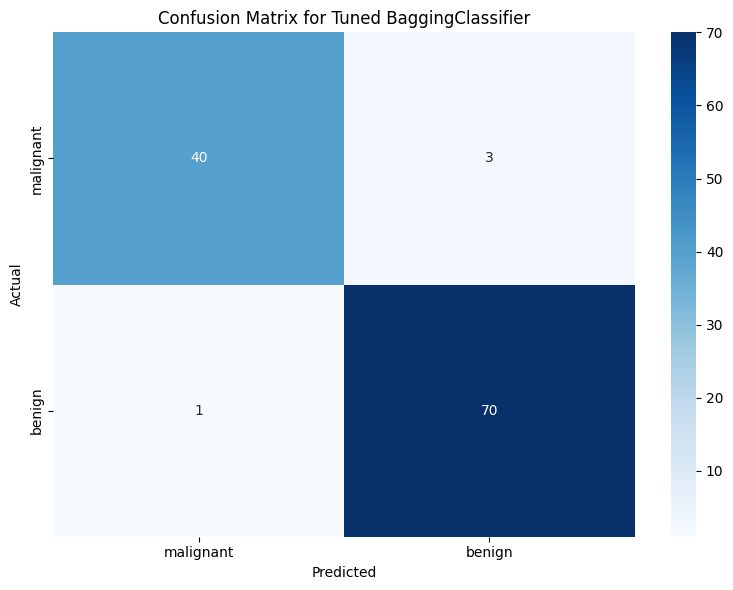

In [19]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=data.target_names, 
            yticklabels=data.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Tuned BaggingClassifier')
plt.tight_layout()
plt.show()

In [20]:
# Visualize feature importance (if available)
if hasattr(best_bag_clf, 'feature_importances_'):
    feature_importances = best_bag_clf.feature_importances_
    feature_names = data.feature_names
    
    # Get top 10 features
    indices = np.argsort(feature_importances)[::-1][:10]
    
    plt.figure(figsize=(10, 6))
    plt.title('Top 10 Feature Importances')
    plt.bar(range(10), feature_importances[indices])
    plt.xticks(range(10), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances not available for this model")

Feature importances not available for this model


In [23]:
# Analyzing the impact of n_estimators
n_estimators_range = [1, 5, 10, 20, 50, 100, 200]
train_scores = []
test_scores = []

for n_estimators in n_estimators_range:
    # Create model with current n_estimators value
    bag = BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=best_bag_clf.estimator_.max_depth),
        n_estimators=n_estimators,
        max_samples=best_bag_clf.max_samples,
        max_features=best_bag_clf.max_features,
        bootstrap=best_bag_clf.bootstrap,
        bootstrap_features=best_bag_clf.bootstrap_features,
        random_state=42
    )
    
    # Train model
    bag.fit(X_train_scaled, y_train)
    
    # Evaluate on train and test sets
    train_score = accuracy_score(y_train, bag.predict(X_train_scaled))
    test_score = accuracy_score(y_test, bag.predict(X_test_scaled))
    
    train_scores.append(train_score)
    test_scores.append(test_score)

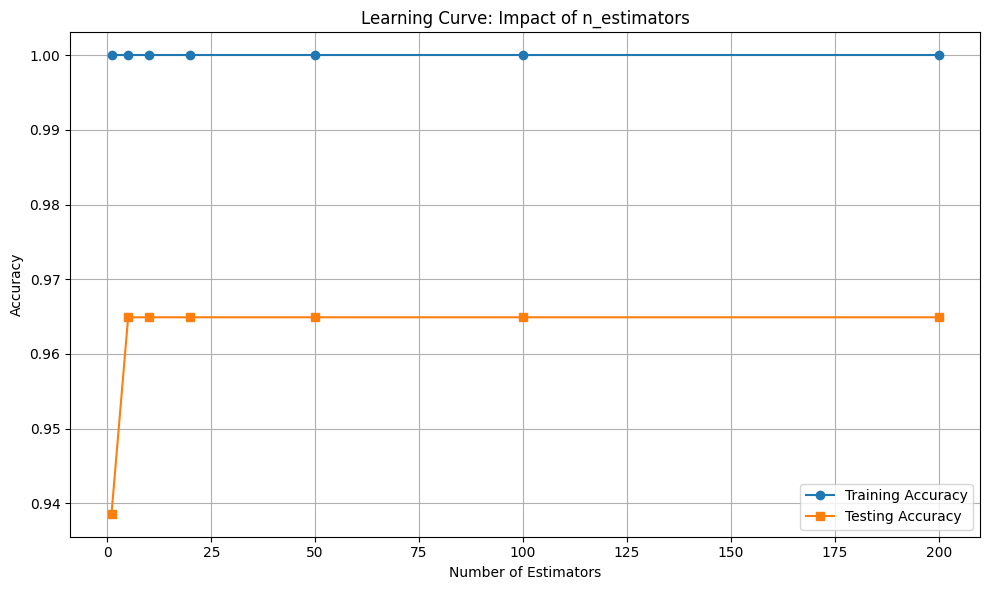

In [24]:
# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores, label='Training Accuracy', marker='o')
plt.plot(n_estimators_range, test_scores, label='Testing Accuracy', marker='s')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Impact of n_estimators')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()